In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import datetime

import IPython
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as lgb
from tqdm import tqdm 
import time

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/대전_한국가스공사_시간별 공급량.csv', encoding='cp949')
data

,연월일,시간,구분,공급량,기온
0,2013-01-01,1,A,2497.129,-8.8
1,2013-01-01,2,A,2363.265,-8.5
2,2013-01-01,3,A,2258.505,-8.5
3,2013-01-01,4,A,2243.969,-9.0
4,2013-01-01,5,A,2344.105,-9.1
...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,-2.8
368084,2018-12-31,21,H,669.961,-3.5
368085,2018-12-31,22,H,657.941,-4.0
368086,2018-12-31,23,H,610.953,-4.6


Training Data Preprocessing

In [ ]:
data = data.fillna(method = 'ffill')

In [ ]:
pd.isnull(data).sum()

연월일    0
시간     0
구분     0
공급량    0
기온     0
dtype: int64

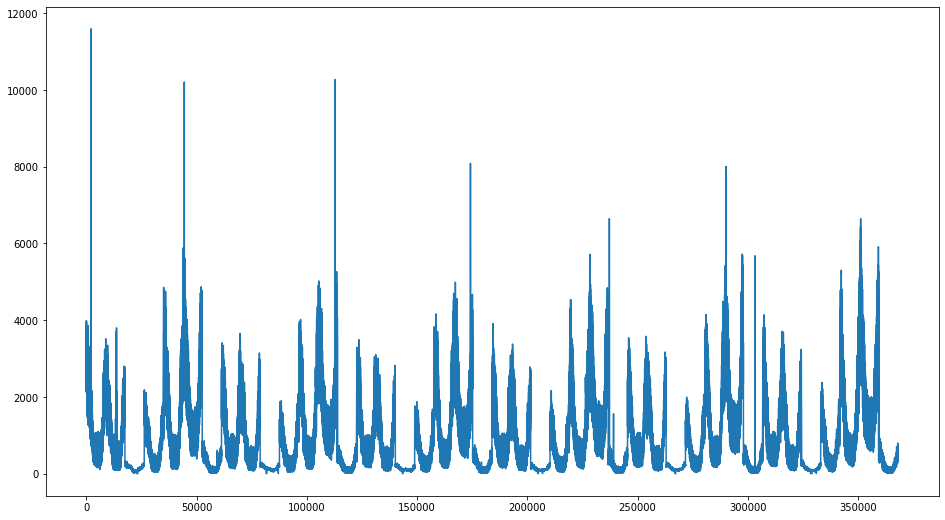

In [ ]:
data['공급량'].plot()

In [ ]:
data['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [ ]:
data['연월일'] = pd.to_datetime(data['연월일'])
data['year'] = data['연월일'].dt.year
data['month'] = data['연월일'].dt.month
data['day'] = data['연월일'].dt.day
data['weekday'] = data['연월일'].dt.weekday

In [ ]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')
data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']

In [ ]:
data['구분'] = data['구분'].astype('category')
data

,연월일,시간,구분,공급량,기온,year,month,day,weekday,월일시
0,2013-01-01,1,A,2497.129,-8.8,2013,1,1,1,01-01_1
1,2013-01-01,2,A,2363.265,-8.5,2013,1,1,1,01-01_2
2,2013-01-01,3,A,2258.505,-8.5,2013,1,1,1,01-01_3
3,2013-01-01,4,A,2243.969,-9.0,2013,1,1,1,01-01_4
4,2013-01-01,5,A,2344.105,-9.1,2013,1,1,1,01-01_5
...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,-2.8,2018,12,31,0,12-31_20
368084,2018-12-31,21,H,669.961,-3.5,2018,12,31,0,12-31_21
368085,2018-12-31,22,H,657.941,-4.0,2018,12,31,0,12-31_22
368086,2018-12-31,23,H,610.953,-4.6,2018,12,31,0,12-31_23


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   연월일      368088 non-null  object  
 1   시간       368088 non-null  object  
 2   구분       368088 non-null  category
 3   공급량      368088 non-null  float64 
 4   기온       368088 non-null  float64 
 5   year     368088 non-null  int64   
 6   month    368088 non-null  int64   
 7   day      368088 non-null  int64   
 8   weekday  368088 non-null  int64   
 9   월일시      368088 non-null  object  
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 25.6+ MB


KNN Imputation

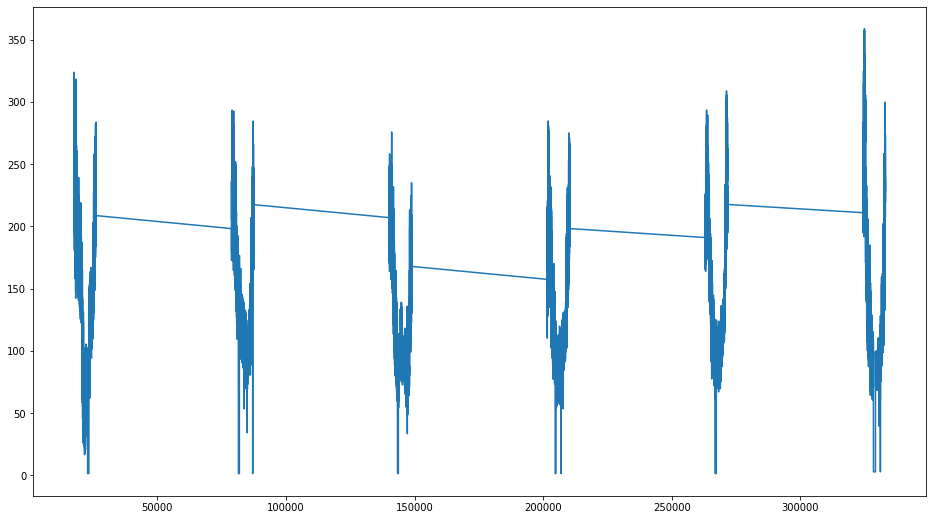

In [ ]:
C = data[data['구분'] == 'C']
C['공급량'].plot()

In [ ]:
data['공급량'] = data['공급량'].apply(lambda x: np.nan if x <= 20 else x)
data

,연월일,시간,구분,공급량,기온,year,month,day,weekday,월일시
0,2013-01-01,1,A,2497.129,-8.8,2013,1,1,1,01-01_1
1,2013-01-01,2,A,2363.265,-8.5,2013,1,1,1,01-01_2
2,2013-01-01,3,A,2258.505,-8.5,2013,1,1,1,01-01_3
3,2013-01-01,4,A,2243.969,-9.0,2013,1,1,1,01-01_4
4,2013-01-01,5,A,2344.105,-9.1,2013,1,1,1,01-01_5
...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,-2.8,2018,12,31,0,12-31_20
368084,2018-12-31,21,H,669.961,-3.5,2018,12,31,0,12-31_21
368085,2018-12-31,22,H,657.941,-4.0,2018,12,31,0,12-31_22
368086,2018-12-31,23,H,610.953,-4.6,2018,12,31,0,12-31_23


In [ ]:
data['공급량'].isnull().sum()

3283

In [ ]:
tmp_data = data.drop(['연월일', '시간', '구분', '월일시'], axis = 1)
tmp_data

,공급량,기온,year,month,day,weekday
0,2497.129,-8.8,2013,1,1,1
1,2363.265,-8.5,2013,1,1,1
2,2258.505,-8.5,2013,1,1,1
3,2243.969,-9.0,2013,1,1,1
4,2344.105,-9.1,2013,1,1,1
...,...,...,...,...,...,...
368083,681.033,-2.8,2018,12,31,0
368084,669.961,-3.5,2018,12,31,0
368085,657.941,-4.0,2018,12,31,0
368086,610.953,-4.6,2018,12,31,0


In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 5, missing_values = np.nan)
tmp_data = imputer.fit_transform(tmp_data)
tmp_data

array([[ 2.497129e+03, -8.800000e+00,  2.013000e+03,  1.000000e+00,
         1.000000e+00,  1.000000e+00],
       [ 2.363265e+03, -8.500000e+00,  2.013000e+03,  1.000000e+00,
         1.000000e+00,  1.000000e+00],
       [ 2.258505e+03, -8.500000e+00,  2.013000e+03,  1.000000e+00,
         1.000000e+00,  1.000000e+00],
       ...,
       [ 6.579410e+02, -4.000000e+00,  2.018000e+03,  1.200000e+01,
         3.100000e+01,  0.000000e+00],
       [ 6.109530e+02, -4.600000e+00,  2.018000e+03,  1.200000e+01,
         3.100000e+01,  0.000000e+00],
       [ 5.608960e+02, -5.200000e+00,  2.018000e+03,  1.200000e+01,
         3.100000e+01,  0.000000e+00]])

In [ ]:
tmp_data = pd.DataFrame(tmp_data)
tmp_data.columns = ['공급량', '기온', 'year', 'month', 'day', 'weekday']
tmp_data

,공급량,기온,year,month,day,weekday
0,2497.129,-8.8,2013.0,1.0,1.0,1.0
1,2363.265,-8.5,2013.0,1.0,1.0,1.0
2,2258.505,-8.5,2013.0,1.0,1.0,1.0
3,2243.969,-9.0,2013.0,1.0,1.0,1.0
4,2344.105,-9.1,2013.0,1.0,1.0,1.0
...,...,...,...,...,...,...
368083,681.033,-2.8,2018.0,12.0,31.0,0.0
368084,669.961,-3.5,2018.0,12.0,31.0,0.0
368085,657.941,-4.0,2018.0,12.0,31.0,0.0
368086,610.953,-4.6,2018.0,12.0,31.0,0.0


In [ ]:
tmp = data.iloc[:, [0, 1, 2, -1]]
tmp

,연월일,시간,구분,월일시
0,2013-01-01,1,A,01-01_1
1,2013-01-01,2,A,01-01_2
2,2013-01-01,3,A,01-01_3
3,2013-01-01,4,A,01-01_4
4,2013-01-01,5,A,01-01_5
...,...,...,...,...
368083,2018-12-31,20,H,12-31_20
368084,2018-12-31,21,H,12-31_21
368085,2018-12-31,22,H,12-31_22
368086,2018-12-31,23,H,12-31_23


In [ ]:
data = pd.concat([tmp_data, tmp], axis = 1)
data

,공급량,기온,year,month,day,weekday,연월일,시간,구분,월일시
0,2497.129,-8.8,2013.0,1.0,1.0,1.0,2013-01-01,1,A,01-01_1
1,2363.265,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,2,A,01-01_2
2,2258.505,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,3,A,01-01_3
3,2243.969,-9.0,2013.0,1.0,1.0,1.0,2013-01-01,4,A,01-01_4
4,2344.105,-9.1,2013.0,1.0,1.0,1.0,2013-01-01,5,A,01-01_5
...,...,...,...,...,...,...,...,...,...,...
368083,681.033,-2.8,2018.0,12.0,31.0,0.0,2018-12-31,20,H,12-31_20
368084,669.961,-3.5,2018.0,12.0,31.0,0.0,2018-12-31,21,H,12-31_21
368085,657.941,-4.0,2018.0,12.0,31.0,0.0,2018-12-31,22,H,12-31_22
368086,610.953,-4.6,2018.0,12.0,31.0,0.0,2018-12-31,23,H,12-31_23


In [ ]:
idx_list = []
sup_rolling_df = pd.DataFrame()

for idx in tqdm(data['구분'].unique()) :
    temp_df = data[data['구분']==idx]
    temp_df['5D_moving_avg'] = temp_df['공급량'].rolling(window=5).mean()
    temp_df['5D_moving_avg'] = temp_df['5D_moving_avg'].fillna(method='backfill')
    sup_rolling_df = sup_rolling_df.append(temp_df)

100%|██████████| 7/7 [00:00<00:00, 12.42it/s]


In [ ]:
sup_rolling_df[sup_rolling_df['구분'] == 'E']

,공급량,기온,year,month,day,weekday,연월일,시간,구분,월일시,5D_moving_avg
35040,3272.837,-8.8,2013.0,1.0,1.0,1.0,2013-01-01,1,E,01-01_1,3047.2642
35041,3057.125,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,2,E,01-01_2,3047.2642
35042,2907.765,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,3,E,01-01_3,3047.2642
35043,2930.789,-9.0,2013.0,1.0,1.0,1.0,2013-01-01,4,E,01-01_4,3047.2642
35044,3067.805,-9.1,2013.0,1.0,1.0,1.0,2013-01-01,5,E,01-01_5,3047.2642
...,...,...,...,...,...,...,...,...,...,...,...
350563,4074.485,-2.8,2018.0,12.0,31.0,0.0,2018-12-31,20,E,12-31_20,3625.2616
350564,4037.720,-3.5,2018.0,12.0,31.0,0.0,2018-12-31,21,E,12-31_21,3799.5736
350565,3954.210,-4.0,2018.0,12.0,31.0,0.0,2018-12-31,22,E,12-31_22,3928.8994
350566,3745.844,-4.6,2018.0,12.0,31.0,0.0,2018-12-31,23,E,12-31_23,3958.3270


In [ ]:
len(sup_rolling_df) == len(data)

True

In [ ]:
sup_rolling_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
공급량,368088.0,953.007769,924.101466,20.036,230.9995,642.8610,1399.40475,11593.6170
기온,368088.0,13.620166,10.878104,-16.900,4.4000,14.5000,22.80000,39.3000
year,368088.0,2015.500228,1.707471,2013.000,2014.0000,2016.0000,2017.00000,2018.0000
month,368088.0,6.523962,3.448424,1.000,4.0000,7.0000,10.00000,12.0000
day,368088.0,15.726609,8.798824,1.000,8.0000,16.0000,23.00000,31.0000
weekday,368088.0,3.000000,2.000003,0.000,1.0000,3.0000,5.00000,6.0000
5D_moving_avg,368088.0,952.991405,911.436006,27.618,243.1611,641.9988,1400.47605,6452.7474


In [ ]:
df = pd.get_dummies(sup_rolling_df, columns = ['구분'])

In [ ]:
df

,공급량,기온,year,month,day,weekday,연월일,시간,월일시,5D_moving_avg,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H
0,2497.129,-8.8,2013.0,1.0,1.0,1.0,2013-01-01,1,01-01_1,2341.3946,1,0,0,0,0,0,0
1,2363.265,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,2,01-01_2,2341.3946,1,0,0,0,0,0,0
2,2258.505,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,3,01-01_3,2341.3946,1,0,0,0,0,0,0
3,2243.969,-9.0,2013.0,1.0,1.0,1.0,2013-01-01,4,01-01_4,2341.3946,1,0,0,0,0,0,0
4,2344.105,-9.1,2013.0,1.0,1.0,1.0,2013-01-01,5,01-01_5,2341.3946,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,681.033,-2.8,2018.0,12.0,31.0,0.0,2018-12-31,20,12-31_20,604.7030,0,0,0,0,0,0,1
368084,669.961,-3.5,2018.0,12.0,31.0,0.0,2018-12-31,21,12-31_21,635.0934,0,0,0,0,0,0,1
368085,657.941,-4.0,2018.0,12.0,31.0,0.0,2018-12-31,22,12-31_22,658.2096,0,0,0,0,0,0,1
368086,610.953,-4.6,2018.0,12.0,31.0,0.0,2018-12-31,23,12-31_23,659.7726,0,0,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368088 entries, 0 to 368087
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   공급량            368088 non-null  float64
 1   기온             368088 non-null  float64
 2   year           368088 non-null  float64
 3   month          368088 non-null  float64
 4   day            368088 non-null  float64
 5   weekday        368088 non-null  float64
 6   연월일            368088 non-null  object 
 7   시간             368088 non-null  object 
 8   월일시            368088 non-null  object 
 9   5D_moving_avg  368088 non-null  float64
 10  구분_A           368088 non-null  uint8  
 11  구분_B           368088 non-null  uint8  
 12  구분_C           368088 non-null  uint8  
 13  구분_D           368088 non-null  uint8  
 14  구분_E           368088 non-null  uint8  
 15  구분_G           368088 non-null  uint8  
 16  구분_H           368088 non-null  uint8  
dtypes: float64(7), object(3), uin

In [ ]:
features = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H', '공급량', '기온', '5D_moving_avg']
X = df[features]

In [ ]:
num = ['5D_moving_avg', '기온']
cat = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H']
X[cat] = X[cat].astype(str)

In [ ]:
train_years = ['2013.0', '2014.0','2015.0','2016.0','2017.0']
val_years = ['2018.0']
train = X[X['year'].isin(train_years)]
val = X[X['year'].isin(val_years)]

In [ ]:
train

,시간,year,month,day,weekday,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H,공급량,기온,5D_moving_avg
0,1,2013.0,1.0,1.0,1.0,1,0,0,0,0,0,0,2497.129,-8.8,2341.3946
1,2,2013.0,1.0,1.0,1.0,1,0,0,0,0,0,0,2363.265,-8.5,2341.3946
2,3,2013.0,1.0,1.0,1.0,1,0,0,0,0,0,0,2258.505,-8.5,2341.3946
3,4,2013.0,1.0,1.0,1.0,1,0,0,0,0,0,0,2243.969,-9.0,2341.3946
4,5,2013.0,1.0,1.0,1.0,1,0,0,0,0,0,0,2344.105,-9.1,2341.3946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306763,20,2017.0,12.0,31.0,6.0,0,0,0,0,0,0,1,517.264,0.1,465.8186
306764,21,2017.0,12.0,31.0,6.0,0,0,0,0,0,0,1,530.896,-0.6,492.7878
306765,22,2017.0,12.0,31.0,6.0,0,0,0,0,0,0,1,506.287,-1.0,510.1782
306766,23,2017.0,12.0,31.0,6.0,0,0,0,0,0,0,1,470.638,-1.1,509.1778


In [ ]:
X_train = train.drop(['공급량', 'year'],axis=1)
y_train = train['공급량']

X_val = val.drop(['공급량', 'year'],axis=1)
y_val = val['공급량']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()   

train_scaled = scaler.fit(X_train)

X_train_ = scaler.fit_transform(X_train)
X_val_ = scaler.fit_transform(X_val)

In [ ]:
print(X_train_.shape, len(y_train), X_val_.shape, len(y_val))

(306768, 13) 306768 (61320, 13) 61320


In [ ]:
# input reshape 3 dim
X_train_t = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_val_t = X_val_.reshape(X_val_.shape[0], X_val_.shape[1], 1)

print("최종 DATA")
print(X_train_t.shape, X_val_t.shape)
print(y_train)

최종 DATA
(306768, 13, 1) (61320, 13, 1)
0         2497.129
1         2363.265
2         2258.505
3         2243.969
4         2344.105
            ...   
306763     517.264
306764     530.896
306765     506.287
306766     470.638
306767     444.618
Name: 공급량, Length: 306768, dtype: float64


**LSTM**

In [ ]:
K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(13, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCH = 100
BATCH_SIZE = 32

In [ ]:
from keras.callbacks import ModelCheckpoint

filename = 'LSTM_checkpoint-trial-002.h5'
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출됩니다
                             patience=5,
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto',           # auto는 알아서 best를 찾습니다. min/max
                             restore_best_weights = True
                            )

history = model.fit(X_train_t, y_train, 
      validation_data=(X_val_t,y_val),
      epochs=100, 
      batch_size=32,
          verbose=1,
      callbacks=[checkpoint] # checkpoint 콜백
     )

Epoch 1/100
9587/9587 [==============================] - ETA: 0s - loss: 1519749.6250
Epoch 00001: val_loss improved from inf to 1680573.62500, saving model to LSTM_checkpoint-trial-002.h5
9587/9587 [==============================] - 61s 6ms/step - loss: 1519749.6250 - val_loss: 1680573.6250
Epoch 2/100
9587/9587 [==============================] - ETA: 0s - loss: 1236409.7500
Epoch 00002: val_loss improved from 1680573.62500 to 1405597.87500, saving model to LSTM_checkpoint-trial-002.h5
9587/9587 [==============================] - 55s 6ms/step - loss: 1236409.7500 - val_loss: 1405597.8750
Epoch 3/100
9585/9587 [============================>.] - ETA: 0s - loss: 1004742.6875
Epoch 00003: val_loss improved from 1405597.87500 to 1151399.25000, saving model to LSTM_checkpoint-trial-002.h5
9587/9587 [==============================] - 56s 6ms/step - loss: 1004673.5000 - val_loss: 1151399.2500
Epoch 4/100
9579/9587 [============================>.] - ETA: 0s - loss: 806808.4375
Epoch 00004: val

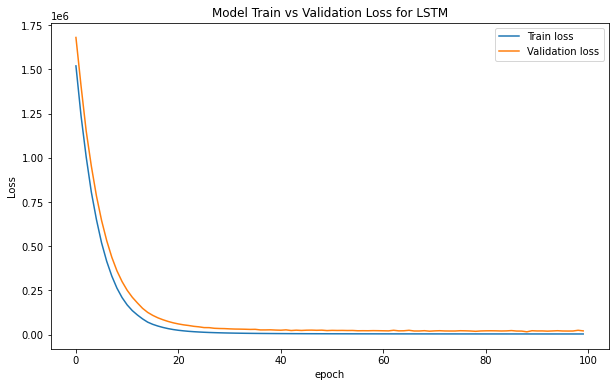

In [ ]:
# loss check
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history, 'LSTM')

In [ ]:
model.save('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/LSTM_checkpoint-trial-002.h5')

In [ ]:
from tensorflow.python.keras.models import load_model

model_LSTM = load_model("LSTM_checkpoint-trial-002.h5")

In [ ]:
# validatation set prediction
y_pred_ = model.predict(X_val_t)

Text(0, 0.5, 'Predict: $\\hat{Y}_i$')

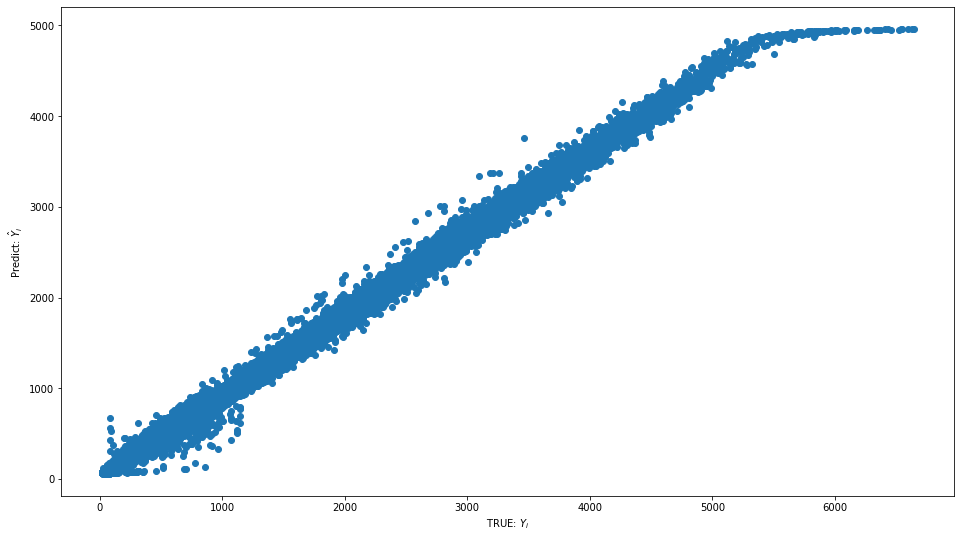

In [ ]:
plt.scatter(y_val, y_pred_)
plt.xlabel("TRUE: $Y_i$")
plt.ylabel("Predict: $\hat{Y}_i$")

METRIC

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred_)
rmse = mse**0.5
r_2 = r2_score(y_val, y_pred_)

print(mse)
print(rmse)
print(r_2)

20575.496025546145
143.44161190375038
0.9796009829105287


**1D CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers

# CNN 
K.clear_session()

model = Sequential()
model.add(layers.Conv1D(32, 2, activation='relu', input_shape=(X_train_t.shape[1],X_train_t.shape[2]))) 
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.Conv1D(32, 2, activation='relu'))
# model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(16, 1, activation='relu'))
model.add(layers.GlobalMaxPooling1D()) 
model.add(layers.Dense(1))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            96        
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            2080      
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 32)            0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 32)             2080      
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 32)             2080      
                                                        

In [ ]:
EPOCH = 100
BATCH_SIZE = 128

In [ ]:
from keras.callbacks import ModelCheckpoint

filename = 'CNN1D_checkpoint-trial-001.h5'
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출됩니다
                             patience=5,
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='min',           # auto는 알아서 best를 찾습니다. min/max
                             restore_best_weights = True
                            )

history = model.fit(X_train_t, y_train, 
      validation_data=(X_val_t,y_val),
      epochs=EPOCH, 
      batch_size=BATCH_SIZE,
          verbose=1,
      callbacks=[checkpoint], # checkpoint 콜백
     )

Epoch 1/100
2397/2397 [==============================] - ETA: 0s - loss: 188147.2969 - mae: 262.9436
Epoch 00001: val_loss improved from inf to 51784.17578, saving model to CNN1D_checkpoint-trial-001.h5
2397/2397 [==============================] - 27s 8ms/step - loss: 188147.2969 - mae: 262.9436 - val_loss: 51784.1758 - val_mae: 149.1424
Epoch 2/100
2394/2397 [============================>.] - ETA: 0s - loss: 36270.4805 - mae: 129.2903
Epoch 00002: val_loss did not improve from 51784.17578
2397/2397 [==============================] - 20s 8ms/step - loss: 36266.3945 - mae: 129.2850 - val_loss: 65608.2500 - val_mae: 165.9681
Epoch 3/100
2393/2397 [============================>.] - ETA: 0s - loss: 30014.4395 - mae: 117.9232
Epoch 00003: val_loss improved from 51784.17578 to 45767.62500, saving model to CNN1D_checkpoint-trial-001.h5
2397/2397 [==============================] - 21s 9ms/step - loss: 30004.1074 - mae: 117.9103 - val_loss: 45767.6250 - val_mae: 137.1059
Epoch 4/100
2393/2397 [

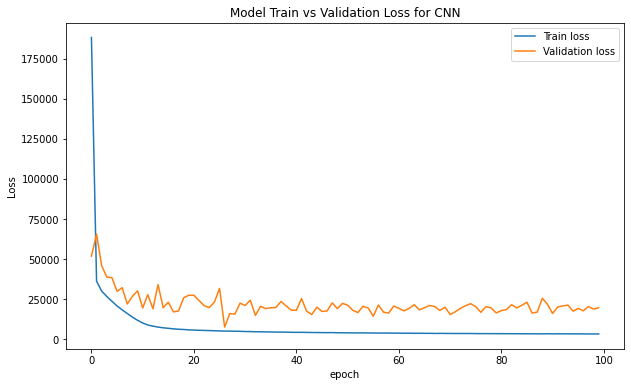

In [ ]:
# loss check
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history, 'CNN')

In [ ]:
model.save('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/CNN1D_checkpoint-trial-001.h5')

In [ ]:
from tensorflow.python.keras.models import load_model

model2 = load_model('CNN1D_checkpoint-trial-001.h5')

In [ ]:
# validatation set prediction
y_pred_ = model2.predict(X_val_t)

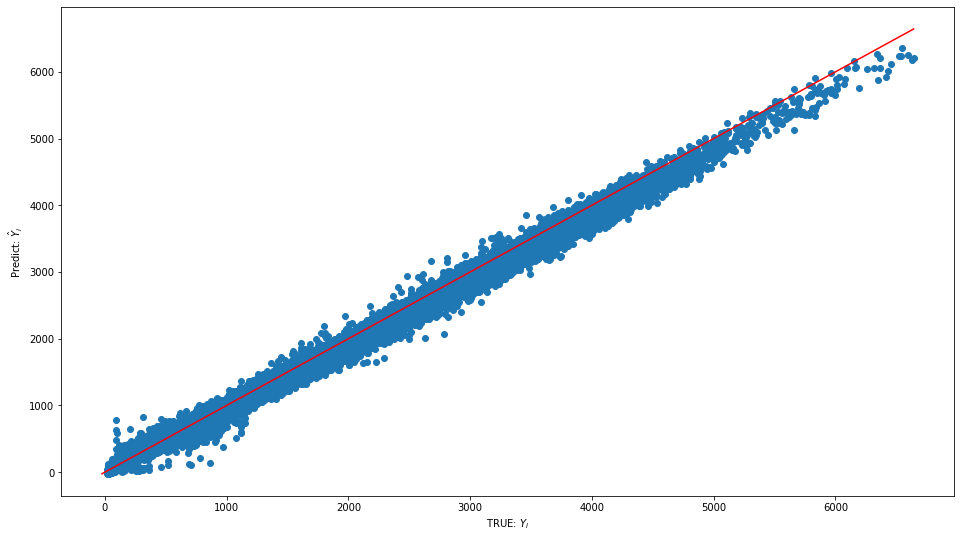

In [ ]:
x = y_val
y = y_pred_

min_val = np.min([x.min(), y.min()])
max_val = np.max([x.max(), y.max()])


plt.scatter(x, y)
plt.xlabel("TRUE: $Y_i$")
plt.ylabel("Predict: $\hat{Y}_i$")

plt.plot([min_val, max_val], [min_val, max_val], color='r')

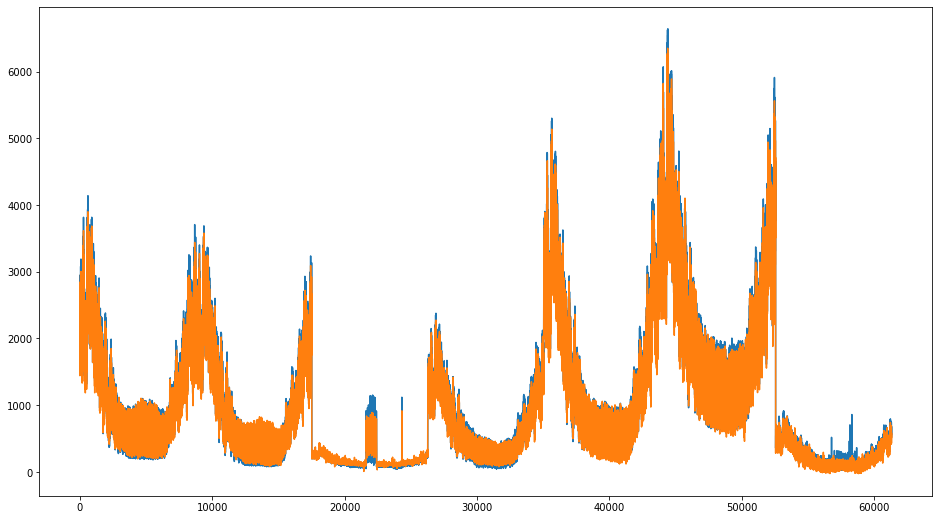

In [ ]:
plt.plot(np.arange(y_val.shape[0]), y_val)
plt.plot(np.arange(y_val.shape[0]), y_pred_)

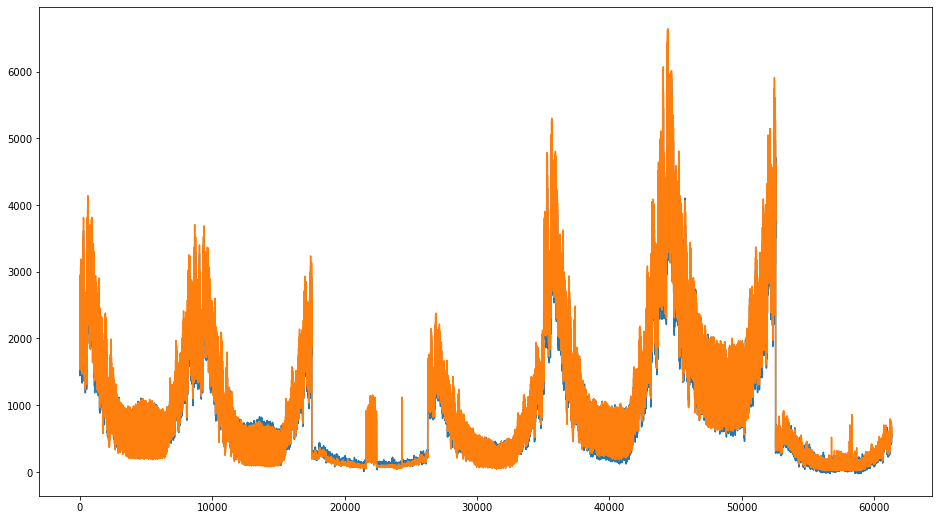

In [ ]:
plt.plot(np.arange(y_val.shape[0]), y_pred_)
plt.plot(np.arange(y_val.shape[0]), y_val)

METRIC

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred_)
rmse = mse**0.5
r_2 = r2_score(y_val, y_pred_)

print(mse)
print(rmse)
print(r_2)

7619.1607875817335
87.28780434620711
0.9924461898308387


Test Data Preprocessing

In [ ]:
# test => inference dataset
test = pd.read_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/test.csv')
submission = pd.read_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/sample_submission.csv')

In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')

test['일자'] = test['일자'].astype('str')
test['시간'] = test['시간'].astype('str')

data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']
test['월일시'] = test['일자'].str[5:] + '_' + test['시간']

In [ ]:
test

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5
...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23


In [ ]:
test['월일시'].unique()

array(['01-01_1', '01-01_2', '01-01_3', ..., '03-31_22', '03-31_23',
       '03-31_24'], dtype=object)

In [ ]:
date = []
supplier = []
mv_avg = []
for i in tqdm(test['월일시'].unique()):
    df_mv_avg = sup_rolling_df[sup_rolling_df['월일시']==i]
    
    for j in df_mv_avg['구분'].unique():
        supplier_mean_df = df_mv_avg[df_mv_avg['구분']==j]
        mean_list = round(np.mean(supplier_mean_df['5D_moving_avg']),4)
     
        date.append(supplier_mean_df['월일시'].iloc[0])
        supplier.append(supplier_mean_df['구분'].iloc[0])
        mv_avg.append(mean_list)

100%|██████████| 2160/2160 [01:05<00:00, 32.92it/s]


In [ ]:
temp_df

,공급량,기온,year,month,day,weekday,연월일,시간,구분,월일시,5D_moving_avg
52560,562.964,-8.8,2013.0,1.0,1.0,1.0,2013-01-01,1,H,01-01_1,523.0568
52561,531.228,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,2,H,01-01_2,523.0568
52562,496.276,-8.5,2013.0,1.0,1.0,1.0,2013-01-01,3,H,01-01_3,523.0568
52563,489.396,-9.0,2013.0,1.0,1.0,1.0,2013-01-01,4,H,01-01_4,523.0568
52564,535.420,-9.1,2013.0,1.0,1.0,1.0,2013-01-01,5,H,01-01_5,523.0568
...,...,...,...,...,...,...,...,...,...,...,...
368083,681.033,-2.8,2018.0,12.0,31.0,0.0,2018-12-31,20,H,12-31_20,604.7030
368084,669.961,-3.5,2018.0,12.0,31.0,0.0,2018-12-31,21,H,12-31_21,635.0934
368085,657.941,-4.0,2018.0,12.0,31.0,0.0,2018-12-31,22,H,12-31_22,658.2096
368086,610.953,-4.6,2018.0,12.0,31.0,0.0,2018-12-31,23,H,12-31_23,659.7726


In [ ]:
temp_df = pd.DataFrame()

In [ ]:
temp_df['월일시'] = date
temp_df['구분'] = supplier
temp_df['5D_moving_avg'] = mv_avg

In [ ]:
temp_df[temp_df['월일시'] == '01-01_4']

,월일시,구분,5D_moving_avg
21,01-01_4,A,1825.0762
22,01-01_4,B,1637.6443
23,01-01_4,C,190.3049
24,01-01_4,D,1110.6390
25,01-01_4,E,2406.0732
26,01-01_4,G,2743.7452
27,01-01_4,H,422.1951


In [ ]:
# 월일시, 구분, 평균
print(supplier_mean_df['월일시'].iloc[0],
supplier_mean_df['구분'].iloc[0],
round(np.mean(supplier_mean_df['5D_moving_avg']),4))

03-31_24 H 298.3528


In [ ]:
test_set = pd.merge(test, temp_df, on = ['구분','월일시'], how = 'left')

In [ ]:
test_set

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시,5D_moving_avg
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1,2095.5065
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2,2002.3103
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3,1907.0166
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4,1825.0762
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5,1779.5306
...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20,239.8929
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21,268.8691
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22,291.2746
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23,302.2607


In [ ]:
avg_temp = pd.read_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/대전_평균기온_for2019.csv', encoding='cp949')
avg = avg_temp['avg6']
avg

0        -2.0
1        -2.3
2        -2.6
3        -2.8
4        -3.2
         ... 
15115    14.2
15116    13.1
15117    12.2
15118    11.5
15119    10.8
Name: avg6, Length: 15120, dtype: float64

In [ ]:
test = pd.concat([test_set, avg], axis=1)
test

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시,5D_moving_avg,avg6
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1,2095.5065,-2.0
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2,2002.3103,-2.3
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3,1907.0166,-2.6
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4,1825.0762,-2.8
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5,1779.5306,-3.2
...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20,239.8929,14.2
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21,268.8691,13.1
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22,291.2746,12.2
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23,302.2607,11.5


In [ ]:
test_dummies = pd.get_dummies(test, columns = ['구분'])

In [ ]:
test_dummies

,일자|시간|구분,일자,시간,year,month,day,weekday,월일시,5D_moving_avg,avg6,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H
0,2019-01-01 01 A,2019-01-01,1,2019,1,1,1,01-01_1,2095.5065,-2.0,1,0,0,0,0,0,0
1,2019-01-01 02 A,2019-01-01,2,2019,1,1,1,01-01_2,2002.3103,-2.3,1,0,0,0,0,0,0
2,2019-01-01 03 A,2019-01-01,3,2019,1,1,1,01-01_3,1907.0166,-2.6,1,0,0,0,0,0,0
3,2019-01-01 04 A,2019-01-01,4,2019,1,1,1,01-01_4,1825.0762,-2.8,1,0,0,0,0,0,0
4,2019-01-01 05 A,2019-01-01,5,2019,1,1,1,01-01_5,1779.5306,-3.2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,2019,3,31,6,03-31_20,239.8929,14.2,0,0,0,0,0,0,1
15116,2019-03-31 21 H,2019-03-31,21,2019,3,31,6,03-31_21,268.8691,13.1,0,0,0,0,0,0,1
15117,2019-03-31 22 H,2019-03-31,22,2019,3,31,6,03-31_22,291.2746,12.2,0,0,0,0,0,0,1
15118,2019-03-31 23 H,2019-03-31,23,2019,3,31,6,03-31_23,302.2607,11.5,0,0,0,0,0,0,1


In [ ]:
features_test = ['시간', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H', 'avg6', '5D_moving_avg']

test_x = test_dummies[features_test]

test_x['시간'] = test_x['시간'].astype(int)

In [ ]:
test_x = scaler.transform(test_x)

In [ ]:
test_t_ = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

In [ ]:
pred_LSTM = model.predict(test_t_)

In [ ]:
pred_LSTM

array([[1670.3248 ],
       [1517.8932 ],
       [1449.4465 ],
       ...,
       [ 279.64273],
       [ 240.18819],
       [ 232.65659]], dtype=float32)

In [ ]:
pred_CNN = model2.predict(test_t_)

In [ ]:
pred_CNN

array([[1668.871  ],
       [1582.562  ],
       [1592.4841 ],
       ...,
       [ 265.34375],
       [ 255.18242],
       [ 236.21263]], dtype=float32)

LSTM과 1D CNN 모델 예측 비교 시각화

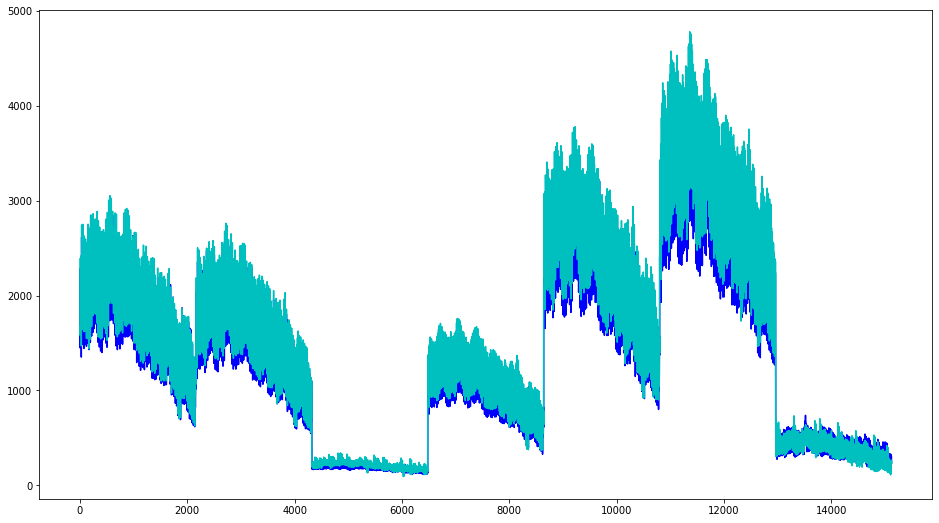

In [ ]:
plt.plot(pred_LSTM, color = 'b')
plt.plot(pred_CNN, color = 'c')

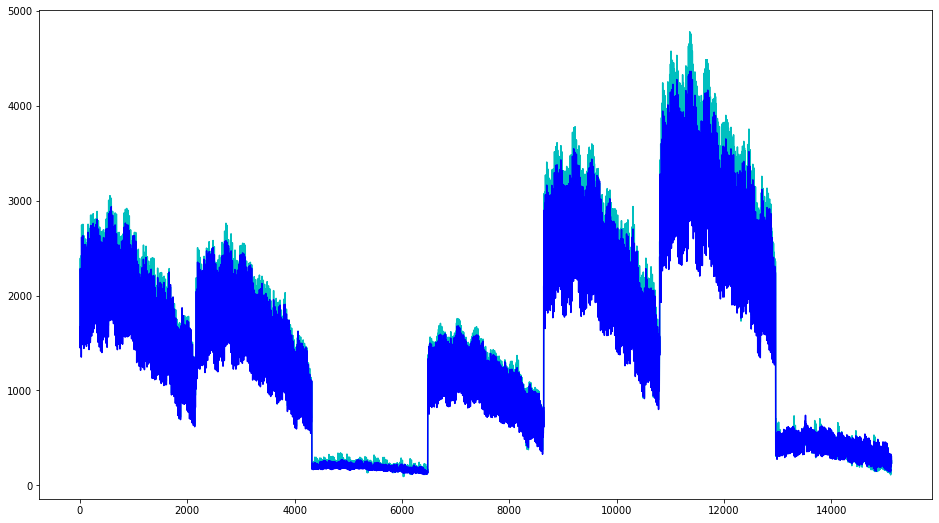

In [ ]:
plt.plot(pred_CNN, color = 'c')
plt.plot(pred_LSTM, color = 'b')

Ensemble

In [ ]:
preds = (pred_LSTM + pred_CNN)/2
preds

array([[1669.5979 ],
       [1550.2275 ],
       [1520.9653 ],
       ...,
       [ 272.49323],
       [ 247.6853 ],
       [ 234.4346 ]], dtype=float32)

In [ ]:
submission['공급량'] = preds

In [ ]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,1669.597900
1,2019-01-01 02 A,1550.227539
2,2019-01-01 03 A,1520.965332
3,2019-01-01 04 A,1631.760010
4,2019-01-01 05 A,1817.551514
...,...,...
15115,2019-03-31 20 H,280.106049
15116,2019-03-31 21 H,276.584656
15117,2019-03-31 22 H,272.493225
15118,2019-03-31 23 H,247.685303


In [ ]:
submission.to_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/submission.csv', index=False)